### Semantic Segmentation using U-Net architecture using (1) VGG and (2) ResNet as the backbone

Task description
1. The first Architecture is U-NET with VGG Net as backbone.
2. The 2nd Architecture is U-NET with ResNeT as the backbone.

**Install necessary libraries**

In [ ]:
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip3 install -U segmentation-models


import tensorflow as tf
import tensorflow.keras as keras
import segmentation_models as sm

     |████████████████████████████████| 516.2 MB 4.1 kB/s 
     |████████████████████████████████| 3.0 MB 46.8 MB/s 
     |████████████████████████████████| 454 kB 68.5 MB/s 
     |████████████████████████████████| 2.9 MB 45.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab202205

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


**Import necessary libraries**

In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob 
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
from tqdm import tqdm
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

**Preparing the datasest**

In [ ]:
SIZE_X=128
SIZE_Y=128
n_classes=12

**Mounting the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Augmenting training data**

In [ ]:
def load_data(path):
    images = sorted(glob.glob(os.path.join(path, "images_prepped_train/*")))
    masks = sorted(glob.glob(os.path.join(path, "annotations_prepped_train/*")))
    return images, masks
    
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augment_data(images, masks, save_path, augment=True):
    H = 128
    W = 128

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:
            aug = CenterCrop(H, W, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            save_images = [x, x1, x2, x3, x4, x5]
            save_masks =  [y, y1, y2, y3, y4, y5]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images_prepped_train", tmp_img_name)
            mask_path = os.path.join(save_path, "annotations_prepped_train", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [ ]:
""" Loading original images and masks. """
path = "/content/drive/MyDrive/A3_Dataset/dataset1/"
images, masks = load_data(path)
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

""" Creating folders. """
create_dir("/content/drive/MyDrive/A3_Dataset/new_data/images_prepped_train")
create_dir("/content/drive/MyDrive/A3_Dataset/new_data/annotations_prepped_train")

""" Applying data augmentation. """
augment_data(images, masks, "/content/drive/MyDrive/A3_Dataset/new_data/", augment=True)

""" Loading augmented images and masks. """
images, masks = load_data("/content/drive/MyDrive/A3_Dataset/new_data/")
print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")

In [ ]:
train_images=[]
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img=cv2.imread(img_path,1)
        img=cv2.resize(img,(SIZE_Y,SIZE_X))
        train_images.append(img)

In [ ]:
train_images=np.array(train_images)

In [ ]:
train_masks=[]
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/"):
    for mask_path in glob.glob(os.path.join(directory_path,"*.png")):
        mask=cv2.imread(mask_path,0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        train_masks.append(mask)

In [ ]:
train_masks=np.array(train_masks)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder= LabelEncoder()
print(train_masks.shape)
n,h,w=train_masks.shape
train_masks_reshaped=train_masks.reshape(-1,1)
train_masks_reshaped_encoded=labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape=train_masks_reshaped_encoded.reshape(n,h,w)
np.unique(train_masks_encoded_original_shape)

(367, 128, 128)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
train_masks_input=np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
test_images=[]
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_test/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img=cv2.imread(img_path,1)
        img=cv2.resize(img,(SIZE_Y,SIZE_X))
        test_images.append(img)

In [ ]:
test_images=np.array(test_images)

In [ ]:
test_masks=[]
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_test/"):
    for mask_path in glob.glob(os.path.join(directory_path,"*.png")):
        mask=cv2.imread(mask_path,0)
        mask=cv2.resize(mask,(SIZE_Y,SIZE_X))
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        test_masks.append(mask)

In [ ]:
test_masks=np.array(test_masks)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder= LabelEncoder()
print(test_masks.shape)
n,h,w=test_masks.shape
test_masks_reshaped=test_masks.reshape(-1,1)
test_masks_reshaped_encoded=labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape=test_masks_reshaped_encoded.reshape(n,h,w)
np.unique(test_masks_encoded_original_shape)

(101, 128, 128)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
test_masks_input=np.expand_dims(test_masks_encoded_original_shape, axis=3)

**Split 20% of training images into validation set** 

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_val, y1, y_val = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)

In [ ]:
X_train=X1
y_train=y1
X_validation=X_val
y_validation=y_val
X_test= test_images
y_test=test_masks_input

In [ ]:
print("Total training images=",X_train.shape[0])
print("Total validation images=",X_validation.shape[0])
print("Total test images=",X_test.shape[0])

Total training images= 293
Total validation images= 74
Total test images= 101


In [ ]:
print("Classes values in the dataset are", np.unique(y_train))

Classes values in the dataset are [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat=to_categorical(y_train, num_classes=12)
print(train_masks_cat.shape)
y_train_cat=train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 12))

(293, 128, 128, 12)


In [ ]:
test_masks_cat=to_categorical(y_test, num_classes=12)
print(test_masks_cat.shape)
y_test_cat=test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 12))

(101, 128, 128, 12)


In [ ]:
val_masks_cat=to_categorical(y_val, num_classes=12)
print(val_masks_cat.shape)
y_val_cat=val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 12))

(74, 128, 128, 12)


**Setting training parameters** 

In [ ]:
n_classes=12
activation='softmax'
LR=0.0001
import tensorflow 
optim=tensorflow.keras.optimizers.Adam(LR)

In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()


'tf.keras'

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


**Using VGG as backbone architecture for training**

In [ ]:
BACKBONE1 = 'vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)


# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics)



print(model1.summary())

history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val_cat))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

37/37 [==============================] - 165s 4s/step - loss: 1.0234 - iou_score: 0.0056 - f1-score: 0.0101 - val_loss: 1.0490 - val_iou_score: 0.0294 - val_f1-score: 0.0458
Epoch 2/30
37/37 [==============================] - 156s 4s/step - loss: 0.9978 - iou_score: 0.0577 - f1-score: 0.0768 - val_loss: 1.0246 - val_iou_score: 0.0536 - val_f1-score: 0.0735
Epoch 3/30
37/37 [==============================] - 157s 4s/step - loss: 0.9782 - iou_score: 0.0916 - f1-score: 0.1171 - val_loss: 1.0184 - val_iou_score: 0.0561 - val_f1-score: 0.0746
Epoch 4/30
37/37 [==============================] - 156s 4s/step - loss: 0.9628 - iou_score: 0.1677 - f1-score: 0.2186 - val_loss: 1.0124 - val_iou_score: 0.0650 - val_f1-score: 0.0907
Epoch 5/30
37/37 [==============================] - 157s 4s/step - loss: 0.9512 - iou_score: 0.2123 - f1-score: 0.2666 - val_loss: 1.0107 - val_iou_score: 0.0774 - val_f1-score: 0.1115
Epoch 6/30
37/37 [==============================] - 157s 4s/step - loss: 0.9430 - iou_

In [ ]:
model1.save('vgg_backbone_30epochs.hdf5')

**Plot the training and validation accuracy and loss at each epoch**

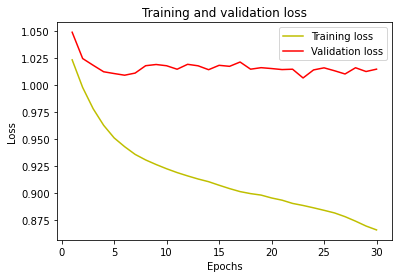

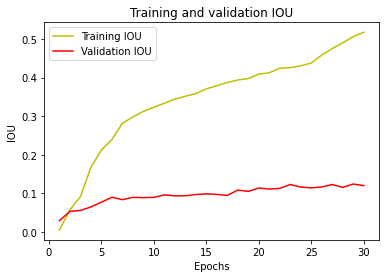

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

**Load the saved model**

In [ ]:
from keras.models import load_model
#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('vgg_backbone_30epochs.hdf5', compile=False)

**MODEL EVALUTION**

Mean IoU = 0.36774826
IoU for class1 is:  0.9501146
IoU for class2 is:  0.95179206
IoU for class3 is:  0.0020449897
IoU for class4 is:  0.98137087
IoU for class5 is:  0.75510865
IoU for class6 is:  0.9296882
IoU for class7 is:  0.1535102
IoU for class8 is:  0.8592281
IoU for class9 is:  0.57802176
IoU for class10 is:  0.015740644
IoU for class11 is:  0.0
IoU for class12 is:  0.48346627


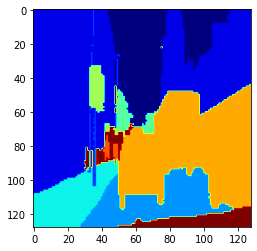

In [ ]:
#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,3]+ values[4,3])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,3]+ values[5,3])
class7_IoU = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3]+ values[6,3]+ values[6,3])
class8_IoU = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3]+ values[7,3]+ values[7,3])
class9_IoU = values[8,8]/(values[8,8] + values[8,0] + values[8,1] + values[8,2] + values[8,3]+ values[8,3]+ values[8,3])
class10_IoU = values[9,9]/(values[9,9] + values[9,0] + values[9,1] + values[9,2] + values[9,3]+ values[9,3]+ values[9,3])
class11_IoU = values[10,10]/(values[10,10] + values[10,0] + values[10,1] + values[10,2] + values[10,3]+ values[10,3]+ values[10,3])
class12_IoU = values[11,11]/(values[11,11] + values[11,0] + values[11,1] + values[11,2] + values[11,3]+ values[11,3]+ values[11,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("IoU for class7 is: ", class7_IoU)
print("IoU for class8 is: ", class8_IoU)
print("IoU for class9 is: ", class9_IoU)
print("IoU for class10 is: ", class10_IoU)
print("IoU for class11 is: ", class11_IoU)
print("IoU for class12 is: ", class12_IoU)

#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='jet')
plt.imshow(train_masks[0], cmap='jet')

**TEST Model on some random images** 

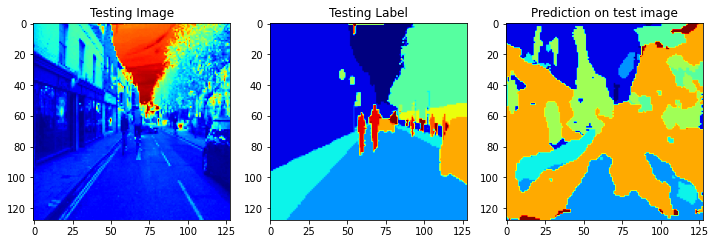

In [ ]:
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

**USING RESNET AS THE BACKBONE**

In [ ]:
###Model 2
BACKBONE2 = 'resnet34'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model2.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val_cat))

Epoch 1/30
37/37 [==============================] - 93s 2s/step - loss: 0.9768 - iou_score: 0.1353 - f1-score: 0.1716 - val_loss: 1.0116 - val_iou_score: 0.1652 - val_f1-score: 0.2142
Epoch 2/30
37/37 [==============================] - 87s 2s/step - loss: 0.9392 - iou_score: 0.2524 - f1-score: 0.2955 - val_loss: 0.9704 - val_iou_score: 0.1610 - val_f1-score: 0.2051
Epoch 3/30
37/37 [==============================] - 87s 2s/step - loss: 0.9177 - iou_score: 0.3389 - f1-score: 0.3993 - val_loss: 0.9436 - val_iou_score: 0.2844 - val_f1-score: 0.3470
Epoch 4/30
37/37 [==============================] - 87s 2s/step - loss: 0.9040 - iou_score: 0.3867 - f1-score: 0.4560 - val_loss: 0.9328 - val_iou_score: 0.3130 - val_f1-score: 0.3810
Epoch 5/30
37/37 [==============================] - 87s 2s/step - loss: 0.8951 - iou_score: 0.4165 - f1-score: 0.4915 - val_loss: 0.9213 - val_iou_score: 0.3530 - val_f1-score: 0.4308
Epoch 6/30
37/37 [==============================] - 87s 2s/step - loss: 0.8892 -

**Plot the training and validation accuracy and loss at each epoch**

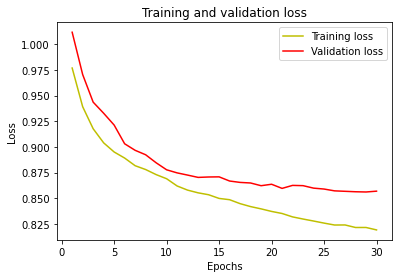

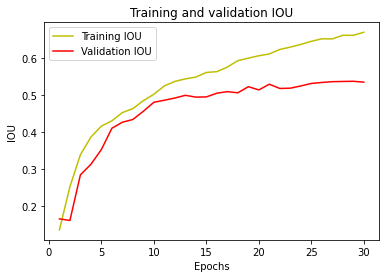

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

**MODEL EVALUTION**

Mean IoU = 0.51452726
IoU for class1 is:  0.95608866
IoU for class2 is:  0.96850526
IoU for class3 is:  0.0076689334
IoU for class4 is:  0.99222434
IoU for class5 is:  0.8849713
IoU for class6 is:  0.95518625
IoU for class7 is:  0.11385816
IoU for class8 is:  0.83627754
IoU for class9 is:  0.8042765
IoU for class10 is:  0.31699276
IoU for class11 is:  0.5036611
IoU for class12 is:  0.5076716


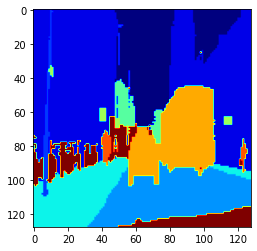

In [ ]:
#IOU
y_pred2=model2.predict(X_test2)
y_pred2_argmax=np.argmax(y_pred2, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,3]+ values[4,3])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,3]+ values[5,3])
class7_IoU = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3]+ values[6,3]+ values[6,3])
class8_IoU = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3]+ values[7,3]+ values[7,3])
class9_IoU = values[8,8]/(values[8,8] + values[8,0] + values[8,1] + values[8,2] + values[8,3]+ values[8,3]+ values[8,3])
class10_IoU = values[9,9]/(values[9,9] + values[9,0] + values[9,1] + values[9,2] + values[9,3]+ values[9,3]+ values[9,3])
class11_IoU = values[10,10]/(values[10,10] + values[10,0] + values[10,1] + values[10,2] + values[10,3]+ values[10,3]+ values[10,3])
class12_IoU = values[11,11]/(values[11,11] + values[11,0] + values[11,1] + values[11,2] + values[11,3]+ values[11,3]+ values[11,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("IoU for class7 is: ", class7_IoU)
print("IoU for class8 is: ", class8_IoU)
print("IoU for class9 is: ", class9_IoU)
print("IoU for class10 is: ", class10_IoU)
print("IoU for class11 is: ", class11_IoU)
print("IoU for class12 is: ", class12_IoU)

#Vaerify the prediction on first image
plt.imshow(train_images[3, :,:,0], cmap='jet')
plt.imshow(train_masks[3], cmap='jet')

**TEST Model on some random images** 

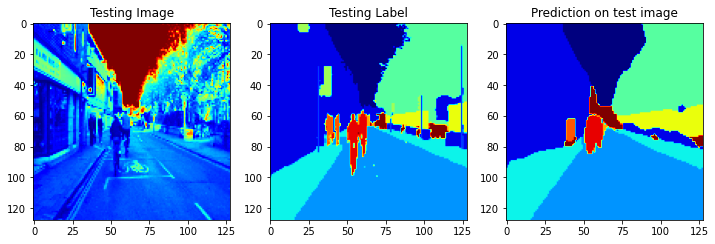

In [ ]:
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()